## Selección de características

### Introducción

Una de las áreas dentro del aprendizaje automático es la ingeniería de características (feature engineering), la cual es el "proceso de seleccionar, crear, o modificar características como variables de entrada o datos para ayudar a los modelos de aprendizaje automático a aprender patrones de manera más efectiva" [1]. Este trabajo se enfocará en la *selección de características*.

El objetivo de este trabajo es **generar un modelo de regresión lineal múltiple que contenga solamente
las variables seleccionadas por un proceso de selección hacia adelante y eliminación hacia atrás**. 

Se trabajará con un conjunto de datos originalmente descargado de la UCI Machine Learning Repository [2], y la descripción de las variables es la siguiente:

- **acidezFija**. La acidez fija del vino, medida en gramos de ácido tartárico por decímetro
cúbico.
- **acidezVolatil**. La acidez volátil del vino, medida en gramos de ácido acético por
decímetro cúbico.
- **acidoCitrico**. Gramos de tácito cítrico por decímetro cúbico.
- **azucarResidual**. Gramos de azúcar por decímetro cúbico.
- **cloruros**. Gramos de cloruro de sodio por decímetro cúbico.
- **dioxidoAzufreLibre**. Miligramos de dióxido de azufre libre por decímetro cúbico.
- **dioxidoAzufreTotal**. Miligramos de dióxido de azufre total por decímetro cúbico.
- **densidad**. Medida en gramos por centímetro cúbico.
- **pH**. Valor del vino en la escala de pH.
- **sulfatos**. Gramos de sulfato de potasio por decímetro cúbico.
- **alcohol**. Volúmen percentil de alcohol en el vino.
- **calidad**. Mediana de la calidad otorgada por al menos tres catadores, en escala del 0
(muy malo) al 10 (excelente).

En este caso, se buscará entrenar un modelo que pueda predecir la calidad de vino de acuerdo con las demás variables explicativas.

El mismo sitio web no es menciona que no hay valores faltantes en el conjunto de datos.

### Preámbulo

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

### Exploración preeliminar

Se importan y exploran los datos:

In [2]:
data = pd.read_csv('Vino Tinto.csv')
print(f"Primeras 5 filas de datos:")
display(data.head())

M = data.shape[0]; N = data.shape[1]
print(f"El conjunto de datos contiene {M} observaciones y {N} variables")

Primeras 5 filas de datos:


,acidezFija,acidezVolatil,acidoCitrico,azucarResidual,cloruros,dioxidoAzufreLibre,dioxidoAzufreTotal,densidad,pH,sulfatos,alcohol,calidad
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


El conjunto de datos contiene 1599 observaciones y 12 variables


Realizar un análisis exploratorio de datos (EDA) exhaustivo no es el objetivo de este trabajo, pero veamos la correlación que tienen las distintas variables del conjunto de datos:

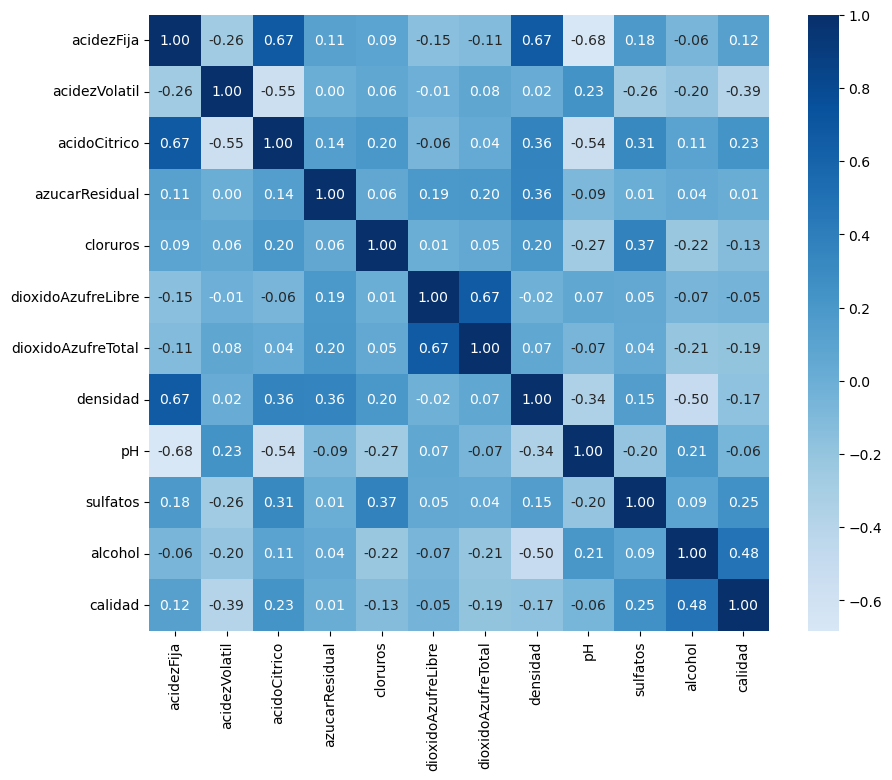

In [3]:
corr = data.corr()
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f', center=0)

Con esta matriz de correlación deberíamos esperar que las variables con mayor correlación absoluta con ``calidad`` sean las más relevantes para el modelo. Por ejemplo, podemos ver que la que tiene mayor correlación positiva es ``alcohol``, mientras que la que tiene mayor correlación negativa es ``acidezVolatil``, así que podríamos esperar que estas estén seleccionadas en el modelo final.

Cabe destacar que además de esas dos variables, ninguna otra variable supera una magnitud de correlación de 0.25, entonces probablemente el modelo final no tenga un desempeño muy bueno.

### Separación de datos

Ahora se realiza una partición aleatoria de datos con la cual trabajar:

In [4]:
x = data.drop('calidad', axis=1)
y = data['calidad']

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=0)

### Modelo base

Para poder apreciar el efecto de la selección de características, entrenemos un modelo base y evaluemos su desempeño:

In [5]:
linearModel = LinearRegression()
linearModel.fit(xTrain, yTrain)
yHatTestBase = linearModel.predict(xTest)
print(f"R^2 del modelo base: {r2_score(yTest, yHatTestBase)}")

R^2 del modelo base: 0.3283887639581424


Debido a que los métodos de selección de características reducirán los modelos, la $R^2$ no será una métrica adecuada para comparar los modelos, ya que esta tiende a aumentar al agregar más variables. Por lo tanto, usaremos la $R^2$ ajustada para ello. Veamos la $R^2$ ajustada del modelo base:

In [6]:
def r2_adj(r_2, n, m):
    # n: número de observaciones
    # m: número de variables explicativas
    r_2_adj = 1 - (1 - r_2) * (m - 1) / (m - n - 1)
    return r_2_adj

r2adj_base = r2_adj(r2_score(yTest, yHatTestBase), N, M)
print(f"R^2 ajustada del modelo base: {r2adj_base}")

R^2 ajustada del modelo base: 0.3233072161444588


### Forward Selection

Se utiliza el proceso de *forward selection* para reducir las caracteristicas del modelo, y se usa validación cruzada para que pueda generalizar mejor

In [7]:
# Forward selection
linearModel = LinearRegression()
sfs = SFS(linearModel, k_features=(3, 11), forward=True, scoring='r2', cv=10)
sfs = sfs.fit(xTrain, yTrain)

print(f"Indices: {sfs.k_feature_idx_}")
print(f"Caracteristicas: {sfs.k_feature_names_}")

Indices: (1, 4, 6, 8, 9, 10)
Caracteristicas: ('acidezVolatil', 'cloruros', 'dioxidoAzufreTotal', 'pH', 'sulfatos', 'alcohol')


Ahora se obtendrán subconjuntos de datos a partir de las variables seleccionadas para entrenar el modelo lineal, y para también evaluar su desempeño.

In [8]:
# Obtener sub conjuntos
feature_idx_list = list(sfs.k_feature_idx_) # convertir una tupla a una lista para usar la propiedad iloc
xTrainFs = xTrain.iloc[:, feature_idx_list] #8 variables en lugar de 11
xTestFS = xTest.iloc[:, feature_idx_list]

# entrenamiento
linearModel.fit(xTrainFs, yTrain) 

# evaluación
yHatTest = linearModel.predict(xTestFS) 
print(f"R^2 con FS: {r2_score(yTest, yHatTest)}") 

R^2 con FS: 0.3269996183251015


### Backwards selection

Se utiliza el proceso de *backwards selection* para reducir las características del modelo

In [9]:
# Backward selection
linearModel = LinearRegression()
sbs = SFS(linearModel, k_features=(2, 4), forward=False, scoring='r2', cv=10)
sbs = sbs.fit(xTrainFs, yTrain)
print(f"Indices: {sbs.k_feature_idx_}")
print(f"Caracteristicas: {sbs.k_feature_names_}")

Indices: (0, 2, 4, 5)
Caracteristicas: ('acidezVolatil', 'dioxidoAzufreTotal', 'sulfatos', 'alcohol')


Entrenamiento, predicciones, y medición de capacidad de predicción tras hacer backwards selection

In [10]:
# obtener sub conjuntos, entrenar, y evaluar (similar a FS)
feature_idx_list_bs = list(sbs.k_feature_idx_)
xTrainFsBs = xTrainFs.iloc[:, feature_idx_list_bs]
xTestFsBs = xTestFS.iloc[:, feature_idx_list_bs]

linearModel.fit(xTrainFsBs, yTrain)

yHatTestFsBs = linearModel.predict(xTestFsBs)
print(f"R^2 con FS: {r2_score(yTest, yHatTestFsBs)}") # r^2

R^2 con FS: 0.3110278056712956


Es visible como entre la $R^2$ de 0.327 del primer modelo y la $R^2$ de 0.311 del segundo modelo hay una diferencia de 16 milésimas. Veamos si con la $R^2$ ajustada, una métrica con la cual podemos comparar mejor modelos con diferentes números variables, obtenemos resultados distintos:

In [11]:
m1 = xTestFS.shape[0]; n1 = xTestFS.shape[1]
m2 = xTestFsBs.shape[0]; n2 = xTestFsBs.shape[1]

r2Adj_fs = r2_adj(r2_score(yTest, yHatTest), n1, m1)
r2Adj_fsbs = r2_adj(r2_score(yTest, yHatTestFsBs), n2, m2)

print("R^2 ajustada de los modelos:\n")
print(f"R^2 ajustada del modelo base: {r2adj_base}")
print(f"R^2 ajustada con FS: {r2Adj_fs}")
print(f"R^2 ajustada con FS y BS: {r2Adj_fsbs}")

R^2 ajustada de los modelos:

R^2 ajustada del modelo base: 0.3233072161444588
R^2 ajustada con FS: 0.31409865254219604
R^2 ajustada con FS y BS: 0.3022789524099787


Podemos ver que la $R^2$ ajustada de todos los modelos es menor que sus respectivas $R^2$, y que la diferencia entre los modelos con selección hacia adelante tanto como con selección adelantes y hacia atrás es de aproximadamente 12 milésimas, entonces vemos que la diferencia en ajuste entre ambos modelos es prácticamente la misma.

Además, la diferencia entre la $R^2$ ajustada del modelo base y los demás modelos es aproximadamente de 1 a 2 décimas, la cual realmente es mínima.

### Conclusiones

Se pudo ver cómo la selección de características pudo ayudar a reducir las variables que el modelo considera con diferencias mínimas en desempeño. En este caso se redujo un modelo con 11 variables explicativas a uno con 4. Si bien puede no parecer mucho, esto puede significar entre tener un modelo de 10,000 variables con una $R^2$ ajustada de 93% a uno de 500 variables con una $R^2$ ajustada de 91%, lo cual puede ser una gran diferencia en cuanto a costos computacional y tiempos de entrenamiento. Dependiendo de la aplicación en la que se quiera implementar un modelo se determinará cuánto ajuste se está dispuesto a sacrificar para reducir el tamaño del modelo, pero al menos este trabajo pudo demostrar el impacto que puede tener la selección de características para reducir la dimensionalidad de un modelo a cambio de una mínima pérdida en desempeño.

### Referencias

[1] GeeksforGeeks. (2025, 8 noviembre). *What is Feature Engineering?* GeeksforGeeks. https://www.geeksforgeeks.org/machine-learning/what-is-feature-engineering/

[2] UCI Machine Learning Repository. (s. f.). https://archive.ics.uci.edu/dataset/186/wine+quality